In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_msssim import SSIM, MS_SSIM
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm  


import sys
import os

# Add the parent directory of src (LPR_Project root) to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from models.unet import UNet  # Now this import should work

from license_plate_dataset import LicensePlateDataset  # Your dataset class

def main():
    # Device configuration (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Hyperparameters
    num_samples = 1000
    num_epochs = 20
    learning_rate = 0.001
    batch_size = 16

    # Image transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create datasets
    train_dataset = LicensePlateDataset(image_dir='data', split='train', num_samples=num_samples, transform=transform)  
    val_dataset = LicensePlateDataset(image_dir='data', split='val', num_samples=num_samples, transform=transform)
    test_dataset = LicensePlateDataset(image_dir='data', split='test', num_samples=num_samples, transform=transform)  

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)  

    # Initialize the model, loss function, and optimizer
    model = UNet(in_channels=3, out_channels=3).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            distorted_images = batch['distorted'].to(device)
            original_images = batch['original'].to(device)

            optimizer.zero_grad()

            outputs = model(distorted_images)
            loss = criterion(outputs, original_images)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * distorted_images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Validate the model
        validate(model, val_loader, criterion, device)

        # Save the model checkpoint
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    # After training is done, evaluate on the test set
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}")

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            distorted_images = batch['distorted'].to(device)
            original_images = batch['original'].to(device)

            outputs = model(distorted_images)
            loss = criterion(outputs, original_images)

            val_loss += loss.item() * distorted_images.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            distorted_images = batch['distorted'].to(device)
            original_images = batch['original'].to(device)

            outputs = model(distorted_images)
            loss = criterion(outputs, original_images)

            test_loss += loss.item() * distorted_images.size(0)

    test_loss /= len(test_loader.dataset)
    return test_loss

if __name__ == "__main__":
    main()


Using device: cuda


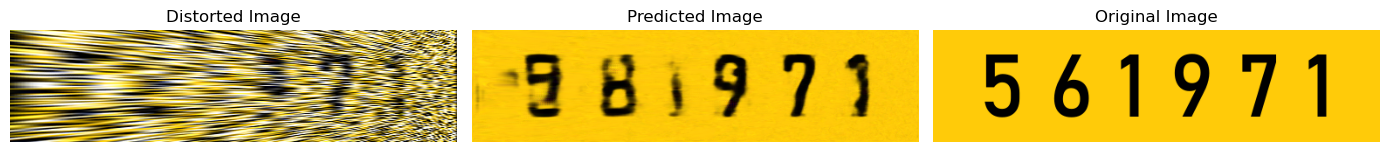

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm  # For progress bars
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

import sys
import os

# Get the current working directory 
notebook_dir = os.getcwd()

# Since your notebook is in the 'notebooks' directory, get the parent directory (project root)
project_root = os.path.dirname(notebook_dir)

# Add the project root to sys.path so Python can find the 'models' directory
if project_root not in sys.path:
    sys.path.append(project_root)

from models.unet import UNet  

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def plot_single_test_output(model, original_path, distorted_path, device, transform=None):
    model.eval()

    # Load the original and distorted images
    original = Image.open(original_path).convert('RGB')
    distorted = Image.open(distorted_path).convert('RGB')

    transform = transforms.ToTensor()  # Convert PIL image to Tensor
    distorted_tensor = transform(distorted).unsqueeze(0).to(device)
    
    # Get the model output (predicted image)
    with torch.no_grad():
        predicted_tensor = model(distorted_tensor).cpu().squeeze(0)  # Remove batch dimension

    # Ensure the predicted tensor is clamped between [0, 1]
    predicted_tensor = torch.clamp(predicted_tensor, 0, 1)

    # Convert tensors to PIL images for visualization
    transform_to_pil = transforms.ToPILImage()
    predicted_image_pil = transform_to_pil(predicted_tensor)

    # Plot the original, distorted, and predicted images
    plt.figure(figsize=(14, 12))

    # Distorted Image
    plt.subplot(1, 3, 1)
    plt.title('Distorted Image')
    plt.imshow(distorted)
    plt.axis('off')

    # Predicted Image (model output)
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image')
    plt.imshow(predicted_image_pil)
    plt.axis('off')

    # Original Image (Ground truth)
    plt.subplot(1, 3, 3)
    plt.title('Original Image')
    plt.imshow(original)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load the model 
model = UNet(in_channels=3, out_channels=3).to(device)

# Construct the path to the model weights
model_weights_path = os.path.join(project_root, 'UNET_Model_1.pth')

# Load the state dictionary (model weights)
state_dict = torch.load(model_weights_path, map_location=device, weights_only=True)

# Load the weights into the model
model.load_state_dict(state_dict)

# Paths to the specific images
original_image_path = os.path.join(project_root, 'data', 'original_0.png')
distorted_image_path = os.path.join(project_root, 'data', 'distorted_0.png')

# Plot the output for the selected image pair
plot_single_test_output(model, original_image_path, distorted_image_path, device)
